### Tensor switching networks

[Tensor Switching Networks](https://arxiv.org/pdf/1610.10087v1.pdf) (sort of) generalise relus. The intuition derives from writing a relu layer's output as:
$$
    X_l = \left(H(W_{l}X_{l-1}) \otimes X_{l-1} \odot W_{l}\right) \times \mathbf{1}^{n_0}
$$

Where $X_i$ is the activation for layer $i$, $W_i$ the weights, $H(\cdot)$ is the [Heaviside step function](https://en.wikipedia.org/wiki/Heaviside_step_function) applied elementwise,
$\odot$ is a kind of broadcasted tensor-matrix Hadamard where we do it for each slice of the tensor. The vector of ones at the end squishes it back down the right shape.

Tensor switching networks simplify slightly by skipping the projection at the end:
$$
    Z_l = H(W_lX_{l-1}) \otimes Z_{l-1}
$$
ensuring $Z_0 = X_0$ is the input to the network. Essentially this just gets gated in complex ways as the tensor grows (with a new dimension for each layer). Finally, just flatten the thing and send it into a standard layer.

There are two issues with this:
1. the tensor gets very large
    - it adds a whole dimension at each layer (although it is likely to be sparse and what is there is just copies).
1. it is impossible to train the weights with normal backprop
    - because $H$ has gradients either 0 or undefined.

The authors offer the following solutions:
1. nothing
2. some crazy schemes including:
    - just use learn only the last layer
    - use nearly the gradients you would get if it were a normal relu net
    - pretty much changing everything into a different kind of network (which is interesting in its own right)
    
    
Here we propose to investigate 2 ideas to solve these issues:
1. use the tensor train format
2. two approaches here:
    - use [this](https://arxiv.org/pdf/1602.02830v3.pdf) method of pretending to back-propagate
    through binarisation.
    - soften $H$ just enough so that it has at least a small region with non-zero gradients.

#### Tensor train tensor products.

If we want to consider the tensor-train decomposition of the tensor that is built at each layer,
we have to answer the following:
What does it mean to do the tensor product of a vector with a tensor in the tt-format?
Let $A$ be a tensor in the tensor-train with elements
$$
    a(i_1, i_2, \ldots, i_d) = G_1[i_1]G_2[i_2]\cdots G_d[i_d]
$$
Consider $C = b \otimes A$ for some $b \in \mathbb{R}^{m}$. This should be the same as making $m$ copies of $A$ and multiplying each copy by different elements of $b$. Then
$$
    c(i_m, i_1, i_2, \ldots, i_d) = b_{i_m} G_1[i_1]G_2[i_2]\cdots G_d[i_d]
$$

So this is equivalent to adding dummy dimensions to make 
$b \in \mathbb{R}^{1\times m\times 1}$ and sticking it on the end of the tensor train.
This seems intuitive on the surface -- we increase the dimensions by adding a new core.
It also starts to make it feel quite suspiciously like we're going to end up with a
pretty standard looking deep net if we apply this to the above tensor switching net.

#### _Tensor train tensor switching network_

We start with an input vector $Z_0 = X_0$, and for each layer $l$ compute:
$$
X_l = H(W_lX_{l-1}) \\
Z_l = X_l \otimes Z_{l-1}
$$
Treating $Z_0$ as the first core of a decomposition,
this gives the following for an element of the penultimate layer:
$$
Z_L(i_L, i_{L-1}, \ldots i_1) = X_L(i_L)X_{L-1}(i_{L-1}) \cdots X_1(i_1).
$$
This is what we would expect. As the X are 0,1 for a value to propagate its way to the output,
every layer has to let it through (but there are exponentially many chances for
this to happen). Curiously, we haven't actually changed anything here -- the decomposition
at this stage buys us nothing as the cores being added have to have tt-rank 1.

The output layer is linear and needs to see all elements of $Z_L$. As we've gone to all the
trouble of keeping $Z_L$ in a tensor train, it makes sense to try and avoid blowing it all
back up right at the end, especially as it turns out to be a very low-rank tensor. The answer
here is to realise what we're actually doing -- we want a linear operation to reduce a tensor
a vector. We want to contract away all the dimensions except one and then project
that to the right size. We can realise this with a single tensor-tensor product
(which should turn out to be equivalent to expanding out the tt, flattening and doing a matrix product). If we 
recognise the tensor-tensor nature of this final layer, we can use a low-rank tensor train
for the output weights and avoid horrible exponential sizes.

Introduce a final weight tensor $U \in \mathbb{R}^{t, n_L \times \cdots \times n_1}$ with a
dimension per layer and an extra output dimension of size $t$. 
Denoting the output of the network $\hat{Y}$, a single element should be
$$
\hat{Y}_k = \sum_{i_L, \ldots i_1} U(k, i_L, \ldots, i_1)Z_L(i_L, \ldots, i_1)
$$ (which affirms the intuition that it is the same as flattening and using matrices).

Recalling the definition of $Z_l$ and letting $U$ be in the tt-format with $L+1$ cores $G_i$,
$$
\hat{Y}_k = \sum_{i_L, \ldots i_1} G_{L+1}(k)G_{L}(i_L)\cdots G_{1}(i_1) X_L(i_L)\cdots X_1(i_1).
$$ Seeing as the $X_j(i_j)$ are all in fact scalars, we can rearrange:
$$
\hat{Y}_k = G_{L+1}(k) \left(\sum_{i_L}G_{L}(i_L) X_L(i_L)\right) \cdots \left(\sum_{i_1}G_1(i_1)\right).
$$ As $G_{L+1}(k)$ is a row vector, $G_{1}(i_1)$ is a column vector and the rest of the $G$
slices are matrices the shapes work out nicely.

We should be able now to define the whole network in one go -- the _analysis_ weights $U$ get
folded in to each layer. This means each layer $l$ essentially has two outputs: the running
product of the reduced $G_l$s (which we term $Y_l$ 
and the most recent activations $X_l$. The activations are used
to compute the next set of activations, which are used to reduce the current $G_l$ which is in
turn used to produce the output $Y_l$. Formally:
$$
X_l = H(W_lX_{l-1}) \\
Y_l = \left(\sum_{i_l}G_l(i_l)X_l(i_l)\right)Y_{l-1}
$$
and finally
$$
\hat{Y} = G_{L+1} Y_L
$$ (technically $G_{L+1}$ is a 3-tensor, but one dimension is 1 so here we treat it as a matrix).

Probably it will turn out to be a good plan to add biases to the linear transformations.

Note that each layer is performing a _bilinear product_ between the current $X$, the previous
$Y$ and the 3-tensor core $G$. We could reduce parameters & computation significantly by
storing the cores themselves in a decomposition -- the CP is good for bilinear products. For
now though, we will just train relatively small nets and deal with the product in its full
glory.

##### training

We have a network, it's kind of nice. At each stage, we make some binary masks and use them to
select slices of the $G$ to combine. The $G$ have a nice linear progression all the way to the
input. The second key issue is still unresolved: how to train the $W_l$. Clearly the $G_l$
should be fine with normal backprop, but the Heaviside step function has zero gradients.
Therefore $W_l$ will never learn and we are doomed.

Tsai, Saxe and Cox propose few methods, the only one which appears to remain relevant involves
computing the pseudoinverse of the gradients of auxiliary variables to derive a
pseudo-gradient for the problematic variables. This seems somewhat unpleasant, so it might
be preferable to avoid it if possible.

An alternative approach for backpropagating through binarising input functions is presented
by [Courbariaux et al.](https://arxiv.org/pdf/1602.02830v3.pdf) (although not for the first
time). They are using a sign function
$$
    q = S(r) = \begin{cases} 1 & r > 0 \\
    -1 & \text{otherwise}
    \end{cases}
$$ to binarize
and use a pseudo-gradient referred to as the _straight through_ estimator (note that it
is not an estimator -- the gradients are 0 or undefined, this does not require estimation).
Using $S^*$ in the place of $S'$ to denote this false gradient, this approach defines:
$$
    S^*(r) = 1_{|r| \leq 1}
$$
That is to say: a gradient of 1 unless the input is outside a certain range. This is precisely
the gradient of the hard tanh function $h(r) = max(-1, min(1, r))$.

The step function we are intending to use is very similar to the sign function above -- the
only difference is that the lowest value it outputs is zero. This suggests we may succeed with
a similar pseudo-gradient, so it is worth a shot. As the threshold is in the same place, there
is probably no need to adjust the above.

An alternative is to relax the decision function into something that does have a 
(sub-)gradient. One answer might be a sigmoid, although these are notoriously poor in deep
feed-forward nets. An answer which retains a lot of desirable properties might be a variation
on the hard tanh above: $s(r) = max(0, min(1, r))$. This is a kind of hard sigmoid, although the
version usually presented shifts and scales the input first.
The scaling and shifting of the input is omitted for two reasons:
firstly, if it is helpful the network should be able to learn it and secondly it maintains the
same boundary as the heaviside step function -- any input less than zero will output zero.

This hard sigmoid has a non-zero gradient when the input is between 0 and 1, so we may be able
to learn something. Let's go ahead and implement both of these and compare on MNIST.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# had to implement the fake gradient activation as its own op
from ops import binary_connect
from functools import partial

bc_01 = partial(binary_connect, min_=0.0)

from rnndatasets import sequentialmnist as data

In [2]:
def hard_sigmoid(activations):
    return tf.maximum(0.0, tf.minimum(1.0, activations))

def ttts_layer(previous_activations, previous_output, hidden_units, tensor_rank,
               nonlin=hard_sigmoid, scope=None):
    """Makes a layer as described above. Tensor rank gets to only be a single integer
    because previous_output should be [batch_size, previous_rank]"""
    with tf.variable_scope(scope or 'ttts_layer'):
        # first compute activations
        input_shape = previous_activations.get_shape()[1].value
        weights = tf.get_variable('weights', shape=[input_shape, hidden_units])
        # give the biases a high-ish init and it will start off basically linear
        biases = tf.get_variable('biases', shape=[hidden_units],
                                 initializer=tf.constant_initializer(1.0))
        acts = tf.nn.bias_add(tf.matmul(previous_activations, weights), biases)
        acts = nonlin(acts)
        
        # now get the tt-core of the output tensor and do a bilinear product with
        # previous_output and acts
        prev_rank = previous_output.get_shape()[1].value
        # we're going to do this all in terms of flattenings, so that we can use the
        # nice big matmuls. The downside is there's a bit of exra storage
        core = tf.get_variable('core', shape=[prev_rank*hidden_units, tensor_rank])
        # if we take the outer product of previous_output and hidden_units then
        # we can just multiply by the above. Regrettably this can be quite large.
        # There's possibly a better way, but that can wait
        outer = tf.batch_matmul(tf.expand_dims(previous_output, 2),
                                tf.expand_dims(acts, 1))
        outer = tf.reshape(outer, [-1, prev_rank*hidden_units])
        output = tf.matmul(outer, core)
        
    return acts, output

def get_full_net(input_var, num_outputs, depth, width, rank, nonlin=hard_sigmoid,
                 scope=None):
    """Gets the full network. Not terribly flexible, all layers are the same
    width and all of the TT cores are the same rank (except where they have
    to be 1)"""
    with tf.variable_scope(scope or 'ttttttttsnettt'):
        activations, outputs = input_var, input_var
        for layer in range(depth):
            activations, outputs = ttts_layer(activations, outputs,
                                              width, rank, nonlin,
                                              'layer_{}'.format(layer))
        # now the last layer is just a linear transform
        # should be rank -> num_outputs
        with tf.variable_scope('output_layer'):
            weights = tf.get_variable('weights', [rank, num_outputs])
            biases = tf.get_variable('biases', [num_outputs])
            result = tf.nn.bias_add(tf.matmul(outputs, weights), biases)
        return result
    
def count_params(scope):
    return np.sum(
        [np.prod([dim for dim in var.get_shape().as_list()]) 
         for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope)])

In [3]:
BATCH_SIZE = 50
LEARNING_RATE = 0.0001  # hand picked -- could probably do better
NUM_EPOCHS = 100
DEPTH = 4  # give it some depth, but not too much
WIDTH = 50 # pretty narrow
RANKS = 50 # also pretty narrow -- does most of the work so should be bigger?

tf.reset_default_graph()
input_pl = tf.placeholder(tf.float32, shape=[BATCH_SIZE, 784], name='inputs')
target_pl = tf.placeholder(tf.int32, shape=[BATCH_SIZE], name='targets')

with tf.variable_scope('hs_net') as scope:
    # default nonlin is hard_sigmoid
    hs_net_out = get_full_net(input_pl, 10, DEPTH, WIDTH, RANKS, scope=scope)
    
    print('hard sigmoid: {} parameters'.format(count_params(scope.name)))
    hs_net_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
        hs_net_out, target_pl)
    hs_net_loss = tf.reduce_mean(hs_net_loss)
    hs_net_acc = tf.contrib.metrics.accuracy(tf.cast(tf.argmax(hs_net_out, 1), tf.int32),
                                             target_pl)
    hs_net_acc = tf.reduce_mean(hs_net_acc)
    opt = tf.train.AdamOptimizer(LEARNING_RATE)
    hs_net_train = opt.minimize(
        hs_net_loss, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope.name))

hard sigmoid: 2382410 parameters


In [4]:
def run_epoch(data_iter, input_var, target_var, metrics, train_op, session):
    """run an epoch over the data, report metrics averaged over all the data"""
    metric_sums = [0 for _ in metrics]
    total_steps = 0
    for image_batch, label_batch in data_iter:
        feed = {input_var: image_batch,
                target_var: label_batch}
        results = session.run(metrics +  [train_op], feed)
        # print some stuff so we know something is happening
        if total_steps % 10 == 0:
            print('\r{:~^50}'.format(
                    ','.join(['{:.4f}'.format(mval) for mval in results[:-1]])),
                    end='', flush=True)
        metric_sums = [old + new for old, new in zip(metric_sums, results[:-1])]
        total_steps += 1
    return [total/total_steps for total in metric_sums]

In [5]:
# now train
hs_train_accs, hs_test_accs = [], []
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    print('initialised')
    train_data = data.get_data('train', 60000)
    # fix the data from RNN format to feed-forward shapes
    # it's a tuple, so redo the sequence
    train_data = [train_data[0].reshape((-1, 784)), train_data[1]]
    test_data = data.get_data('test', 10000)
    test_data = [test_data[0].reshape((-1, 784)), test_data[1]]
    
    for epoch in range(NUM_EPOCHS):
        train_iter = data.batch_iter(train_data, BATCH_SIZE, False)
        xent, acc = run_epoch(train_iter, input_pl, target_pl,  # data
                              [hs_net_loss, hs_net_acc],  # things to report back on
                              hs_net_train,  # thing to do training
                              sess)  # session to run it all
        print('\rEpoch {}:\n~~Train: xent {}, accuracy {}'.format(epoch, xent, acc))
        # record for plotting later
        hs_train_accs.append(acc)
        
        # run it on the test data
        test_iter = data.batch_iter(test_data, BATCH_SIZE, False)
        xent, acc = run_epoch(test_iter, input_pl, target_pl,  # data
                              [hs_net_loss, hs_net_acc],  # things to report back on
                              tf.no_op(),  # no training
                              sess)  # session to run it all
        print('\r~~~Test: xent {}, accuracy {}'.format(xent, acc))
        hs_test_accs.append(acc)

initialised
Epoch 0:
~~Train: xent 0.3463801920600236, accuracy 0.8925666605681181
~~~Test: xent 0.2738124559400603, accuracy 0.9149999982118606
Epoch 1:
~~Train: xent 0.1683496132503448, accuracy 0.9484333301583926
~~~Test: xent 0.1774616651411634, accuracy 0.9452999988198281
Epoch 2:
~~Train: xent 0.12924621582227702, accuracy 0.9603833317756653
~~~Test: xent 0.18458495072845835, accuracy 0.9489999982714653
Epoch 3:
~~Train: xent 0.10749417396938953, accuracy 0.9667666667699814
~~~Test: xent 0.13052590952051105, accuracy 0.9611999988555908
Epoch 4:
~~Train: xent 0.08995180243745683, accuracy 0.9719833329319953
~~~Test: xent 0.11905728896375876, accuracy 0.96719999730587
Epoch 5:
~~Train: xent 0.07760984522086802, accuracy 0.9765833320717017
~~~Test: xent 0.14658296506320767, accuracy 0.9590999984741211
Epoch 6:
~~Train: xent 0.06843498543329891, accuracy 0.9780833318829536
~~~Test: xent 0.13979959484460777, accuracy 0.9631999999284744
Epoch 7:
~~Train: xent 0.060022675353631406, accu

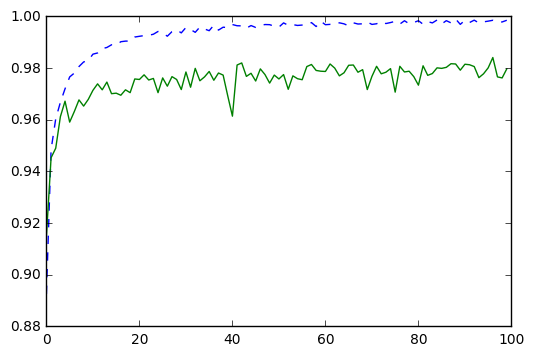

In [6]:
x = np.arange(len(hs_train_accs))
plt.plot(x, hs_train_accs, ls='dashed', label='train')
plt.plot(x, hs_test_accs, label='test')

for extreme laziness, copy and paste to test with the proper binarization and fake gradients

In [7]:
tf.reset_default_graph()

# can't do this one on GPU because I haven't done a GPU implementation of the binary connect
# it seems like it shouldn't be hard, but in practive it's turned out to be a big pain
# so we'll just pin everything to the cpu, tbh it doesn't seem to slow down much

with tf.device('/cpu:0'):
    input_pl = tf.placeholder(tf.float32, shape=[BATCH_SIZE, 784], name='inputs')
    target_pl = tf.placeholder(tf.int32, shape=[BATCH_SIZE], name='targets')

    with tf.variable_scope('bc_net') as scope:
        # default nonlin is hard_sigmoid
        bc_net_out = get_full_net(input_pl, 10, DEPTH, WIDTH, RANKS, 
                                  nonlin=bc_01, scope=scope)
        # should have the same number of params
        print('binarised: {} parameters'.format(count_params(scope.name)))
        bc_net_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
            bc_net_out, target_pl)
        bc_net_loss = tf.reduce_mean(bc_net_loss)
        bc_net_acc = tf.contrib.metrics.accuracy(tf.cast(tf.argmax(bc_net_out, 1), tf.int32),
                                                 target_pl)
        bc_net_acc = tf.reduce_mean(bc_net_acc)
        opt = tf.train.AdamOptimizer(LEARNING_RATE)
        bc_net_train = opt.minimize(
            bc_net_loss, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope.name))

binarised: 2382410 parameters


In [8]:
# now train
bc_train_accs, bc_test_accs = [], []
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    print('initialised')
    train_data = data.get_data('train', 60000)
    # fix the data from RNN format to feed-forward shapes
    # it's a tuple, so redo the sequence
    train_data = [train_data[0].reshape((-1, 784)), train_data[1]]
    test_data = data.get_data('test', 10000)
    test_data = [test_data[0].reshape((-1, 784)), test_data[1]]
    
    for epoch in range(NUM_EPOCHS):
        train_iter = data.batch_iter(train_data, BATCH_SIZE, False)
        xent, acc = run_epoch(train_iter, input_pl, target_pl,  # data
                              [bc_net_loss, bc_net_acc],  # things to report back on
                              bc_net_train,  # thing to do training
                              sess)  # session to run it all
        print('\rEpoch {}:\n~~Train: xent {}, accuracy {}'.format(epoch, xent, acc))
        # record for plotting later
        bc_train_accs.append(acc)
        
        # run it on the test data
        test_iter = data.batch_iter(test_data, BATCH_SIZE, False)
        xent, acc = run_epoch(test_iter, input_pl, target_pl,  # data
                              [bc_net_loss, bc_net_acc],  # things to report back on
                              tf.no_op(),  # no training
                              sess)  # session to run it all
        print('\r~~~Test: xent {}, accuracy {}'.format(xent, acc))
        bc_test_accs.append(acc)

initialised
Epoch 0:
~~Train: xent 0.4320283618379229, accuracy 0.8689833291930457
~~~Test: xent 0.4095760886371136, accuracy 0.8795999950170517
Epoch 1:
~~Train: xent 0.23645046083411822, accuracy 0.9290166637798151
~~~Test: xent 0.25378319273586386, accuracy 0.9231999996304512
Epoch 2:
~~Train: xent 0.18297053255004964, accuracy 0.9445666648944219
~~~Test: xent 0.2320017692190595, accuracy 0.9337999978661538
Epoch 3:
~~Train: xent 0.15154321974230697, accuracy 0.9541666665673256
~~~Test: xent 0.2420175416325219, accuracy 0.9329999977350235
Epoch 4:
~~Train: xent 0.1351983101015018, accuracy 0.9588166661560535
~~~Test: xent 0.1823917568138495, accuracy 0.948599997162819
Epoch 5:
~~Train: xent 0.11121558389550046, accuracy 0.9661500006914139
~~~Test: xent 0.161757962860338, accuracy 0.955199998319149
Epoch 6:
~~Train: xent 0.10136402207133263, accuracy 0.9687666674951713
~~~Test: xent 0.168711089471617, accuracy 0.9524999991059303
Epoch 7:
~~Train: xent 0.09090463975067299, accuracy 0.

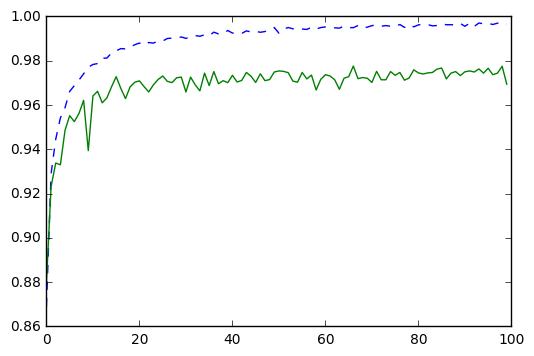

In [9]:
x = np.arange(len(bc_train_accs))
plt.plot(x, bc_train_accs, ls='dashed', label='train')
plt.plot(x, bc_test_accs, label='test')

### Comparison

Note that a fully connected net, even with just two layers, will probably get 97-98% with
this many parameters, so that's about the same. The best we did was:

Best hard sigmoid: 0.9840999999642372
Best binary: 0.9776000019907951


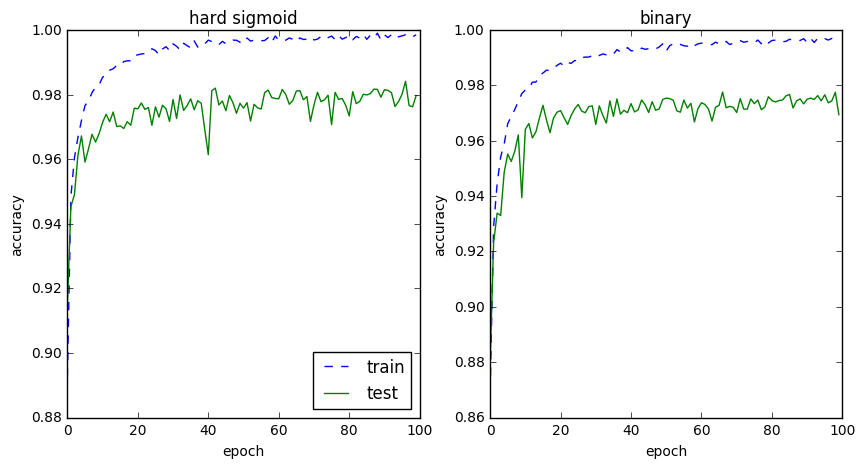

In [12]:
print('Best hard sigmoid: {}\nBest binary: {}'.format(
    np.max(hs_test_accs), np.max(bc_test_accs)))

# have a look at them next to each other
plt.figure(figsize=(10, 5))
plt.subplot(121)
x = np.arange(len(hs_train_accs))
plt.plot(x, hs_train_accs, ls='dashed', label='train')
plt.plot(x, hs_test_accs, label='test')
plt.legend(loc='lower right')
plt.title('hard sigmoid')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.subplot(122)
x = np.arange(len(hs_train_accs))
plt.plot(x, bc_train_accs, ls='dashed', label='train')
plt.plot(x, bc_test_accs, label='test')
plt.title('binary')
plt.ylabel('accuracy')
plt.xlabel('epoch')

They're pretty much the same shapes, although the hard sigmoid seems to maybe train just a little bit faster.
This is interesting because the hard sigmoid has more holes in its gradient -- anything < 0 or > 1 has a 0 gradient,
while the fake gradient for the binarisation is 1 iff -1 < input < 1, so has a wider range of linear values. Perhaps
this suggests we should use the hard sigmoid gradient instead of the hard tanh for the binary activations.

Test accuracy-wise, as the result of a single trial they're pretty much indistinguishable, and not too shabby
(if we didn't get close to the 98% mark with this many parameters it would be embarrassing). Hard sigmoid is looking
nice though.

##### We haven't lost anything
but what did we gain?

One argument would be interpretability:
- the cores of the tensor train-ed analysis weights give us sets of hierarchical feature extractors
- the activations tell us which of the feature extractors were chosen

It's relatively straightforward to see how this lets the network show its working in a sense.
If we conducted some analysis of which feature extractors were used when we might be able to get a
sense of what the network does when. Separating analysis and activations _may_ make this easier
than in a standard net.

We've gained vanishing gradients. This is not so good. The original formulation was nice in the sense
that the final output layer was present with the results from all preceding layers. This naturally
should deal to the possibility of the gradients vanishing (aside from the fact that a lot of them are
0 because of the step function). By representing these output weights as a tensor-train, we get this
nice-ish gated deep network architecture, but we lose the skip-like connections directly connecting
each layer to the output as we now have to back-propagate through all the cores of the tensor-train.
This part is at least all linear, so it shouldn't decay too wildly due to activations saturating
or relu-shattering. However, it's still not going to be perfect (we could try and initialise all the
slices of the cores to be orthogonal if its seriously deep, but there's no guarantees once it starts
training).

Note that the gradienst won't vanish quite as badly as in a purely deep net. Given the hard saturation
of the activations, back-propagating purely through the $X$s would be a nightmare, but we don't
just do that. There is also a linear path for the gradients to follow through the tensor cores $G$.
This doesn't solve the problem as effectively as skip connections might, but it should certainly help.

It's still an interesting idea: we're running two deep, thin networks in parallel and using one to gate
the other. Each network is aggressively simple: one is purely (bi)linear, the other uses binary
activations. Despite this they work together and at least equal a net with a lot more hidden units.

Finally, it's worth reiterating the intepretation intuited above. Each layer has a set of possible weight
matrices (stored in the three-tensor $G$). The binary(ish) activations $X$ choose a subset of these
matrices to add together producing a weight matrix for the current layer of a linear net. This gives
us two co-dependent networks, with nicely separate tasks. One network (tensor cores $G$) needs to learn
composable, hierarchical feature maps which provide the basis for the classification. The other network
(the binary $X$s) needs to learn to take a rough glance at the input and estimate which of the feature maps
will be useful.

##### future directions
The network is derived from fairly sound ideas, but there are questions to adress:
- the number of parameters is still very large
    - could further decompose the cores, eg. with a CP decomposition
    - experiment with different ratios of tt-rank/hidden units
    - a standard relu shares analysis & activation weights. This is efficient, but
      potential not fully expressive. Can we introduce some kind of soft weight
      sharing between the analysis cores and the weights at each layer to try and
      manage this balance?
- how to do a conv net?
    - given the interpretation above, perhaps the convolution is best introduced in
      somewhere in the tensor-train cores? This seems a bit messy, but necessary if
      we want to deal with big pictures. Probably would have to make the $X$ somehow
      convolutional too.
- how to make it faster?
    - obviously decomposing the cores, but there should be other ways to avoid the
      outer product of the $Y_{l-1}$ and $X$ (such as broadcasting the $X$ appropriately
      across the $G$ and summing it down to a matrix -- this gets awkward with batches > 1).
- neither of the activations really makes sense
    - there is probably a better way to train through the binarisation
    - could imagine treating it as online learning, where the binarisation is projection
      onto corners of the hypercube and try to derive an lazy online mirror descent
      style update?